# Семинар №4 по курсу "Распознавание образов"

# Линейный дискриминантный анализ (LDA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from math import sqrt, exp, pi
from scipy.stats import norm
from matplotlib.colors import ListedColormap

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats

# I. Общее рассмотрение базовых алгоритмов машинного обучения


## 1. Изучение алгоритма классификации на основе метода линейного дискриминантного анализа


Линейный дискриминантный анализ (ЛДА, англ. Linear Discriminant Analysis, LDA) является обобщением линейного дискриминанта Фишера, метода, используемого в статистике, распознавании образов и обучении машин для поиска линейной комбинации признаков, которая описывает или разделяет два или более классов или событий.

### LDA как метод понижения размерности

Рассмотрим отношение _межклассовой дисперсии_ к _внутриклассовой дисперсии_ для линейной комбинации признаков $w^{\top}x$:
$$
S = \frac{w^{\top}\Sigma'w}{w^{\top}\Sigma w},
$$
где
$$
\Sigma = \frac{1}{N-K} \sum_{k=1}^K \sum_{y^{(i)}=k} (x^{(i)} - \mu_k) (x^{(i)} - \mu_k)^{\top}
$$
– эмпирическая матрица ковариаций;
$$
\Sigma' = \frac{1}{K} \sum_{k=1}^K (\mu_k - \mu) (\mu_k - \mu)^{\top}
$$
– матрица ковариаций средних, $\mu$ – матожидание средних.

Максимум величины $S$ достигается на векторе $w$

### Линейный дискриминантный анализ



_Априорная вероятность_:

$$
{\rm Pr\,} y
$$

_Апостериорная вероятность_:

$$
{\rm Pr\,}(y \mid x) = \frac{p(x\mid y)\, {\rm Pr\,} y}{p(x)}\
$$

Линейный дискриминантный анализ (LDA) делает два предположения:

 - объекты каждого класса распределены по нормальному закону:

$$
p(x\mid y) = \frac{1}{\sqrt{(2\pi)^d\det\Sigma_y}}e^{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma_y^{-1}(x-\mu_y)}
$$

 - матрицы ковариации $\Sigma = \Sigma_y$ одинаковы для всех классов


Нам нужно сравнить две апостериорные вероятности:

$$
{\rm Pr\,}(y \mid x) > {\rm Pr\,}(y' \mid x)
$$

Подставляя выражения для $p(x\mid y)$ и $p(x\mid y')$ и логарифмируя, приходим к неравенству:

$$
{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y)} + \ln {\rm Pr\,} y
>
{-\frac{1}{2}(x-\mu_{y'})^{\top}\Sigma^{-1}(x-\mu_{y'})} + \ln {\rm Pr\,} y'
$$

Откуда

$$
(\mu_y - \mu_{y'})^{\top} \Sigma^{-1} x >
\frac{1}{2}\mu_{y}^{\top}\Sigma^{-1}\mu_{y} - \frac{1}{2}\mu_{y'}^{\top}\Sigma^{-1}\mu_{y'}
- \ln {\rm Pr\,} y+ \ln {\rm Pr\,} y'
$$
т. е.
$$
w^{\top} x > c,
$$
где $w = (\mu_y - \mu_{y'})^{\top} \Sigma^{-1}$, а $c$ – некоторая константа.

Таким образом,

* уравнение $w^{\top} x = c$ задает разделяющую гиперплоскость между классами $y$ и $y'$
* важна линейная комбинация признаков $x$ с коэффициентами $w$

Введем _линейную дискриминантную функцию_:
$$
\delta_y(x) =
- \frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y) + \frac{1}{2}x^{\top}\Sigma^{-1}x + \ln {\rm Pr}\,y
= \mu_y^{\top} \Sigma^{-1} x  - \frac{1}{2}\mu_y^{\top}\Sigma^{-1}\mu_y + \ln {\rm Pr}\,y
$$

Классификатор: объект $x$ относим к тому классу $y$, для которого $\delta_y(x)$ максимальна.

Здесь
$$
\rho(x,x') = \sqrt{(x-x')^{\top}\Sigma^{-1}(x-x')}
$$
– это _расстояние Махаланобиса_.


## 1.1. Генерация данных
Для двух классов условные вероятности данных в каждом из классов подчиняются двумерному нормальному распределению с параметрами:
- первый класс: среднее значение = [1; 3], СКО = [0,7; 0,8], коэффициент корреляции = 0,2.
- второй класс: среднее значение = [3;2], СКО = [0,3; 1,8], коэффициент корреляции = 0,7.

При расчете принять априорные вероятности классов одинаковыми.

Для первого класса:

In [2]:
# First class parameters
N_train = 6000 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_1 = np.array([1, 3]) # Mean value
std_1 = np.array([0.7, 0.8]) # Standard deviation
cor_coef_1 = 0.2 # Correlation coefficient
prob_1 = 0.5 # Class 1 prior probability
# Correlation matrix
sigma_1 = np.array([[std_1[0]**2, cor_coef_1*std_1[0]*std_1[1]], [cor_coef_1*std_1[0]*std_1[1], std_1[1]**2]])

In [3]:
sigma_1

array([[0.49 , 0.112],
       [0.112, 0.64 ]])

In [4]:
train_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_train)
test_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_test)

Для второго класса:

In [5]:
# Second class parameters
N_train = 6000 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_2 = np.array([3, 2]) # Mean value
std_2 = np.array([0.3, 1.8]) # Standard deviation
cor_coef_2 = 0.7 # Correlation coefficient
prob_2 = 0.5 # Class 2 prior probability
# Correlation matrix
sigma_2 = np.array([[std_2[0]**2, cor_coef_2*std_2[0]*std_2[1]], [cor_coef_2*std_2[0]*std_2[1], std_2[1]**2]])

In [8]:
sigma_2

array([[0.09 , 0.378],
       [0.378, 3.24 ]])

In [6]:
train_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_train)
test_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_test)

Построим классы на плоскости исходного пространства

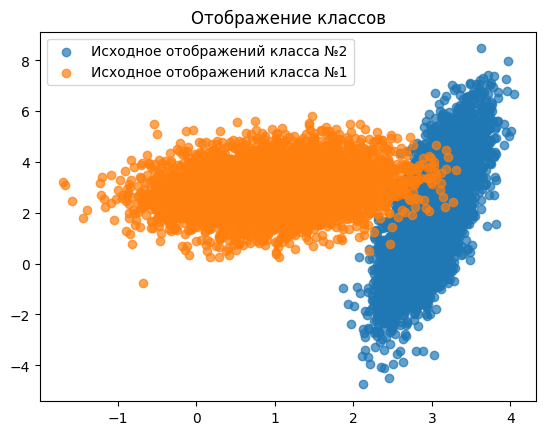

In [7]:
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.title("Отображение классов")
plt.legend()
plt.show()

## 1.2 По группе обучения выполнить расчет проекционного вектора методом ЛДА
Расчет матриц внутриклассовых разбросов и общей матрицы внутриклассового разброса.

In [9]:
Sw1 = np.cov(train_data_1.T)
Sw2 = np.cov(train_data_2.T)
Sw = (Sw1 + Sw2)/2
Sw

array([[0.2939088 , 0.24180579],
       [0.24180579, 1.93940956]])

Расчет вектора перехода

In [10]:
W = np.dot(np.linalg.inv(Sw),(mean_1 - mean_2).T)
W

array([-8.05534061,  1.51996157])

Определение коэффициентов прямой

In [11]:
Y1 = W.T*train_data_1
Y2 = W.T*train_data_2
b = W[1]/W[0]
X = np.append(train_data_1[:,0], train_data_2[:,0])
Y = np.append(train_data_1[:,1], train_data_2[:,1])
a = np.mean(Y) - b*np.mean(X)

In [16]:
np.mean(Y) - b*np.mean(X)

2.874233311631712

Построение разделяющей прямой

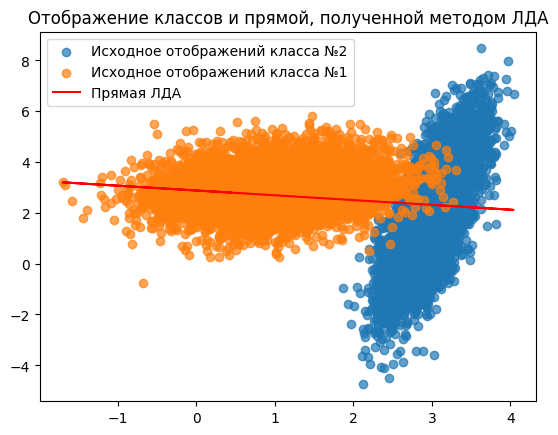

In [12]:
Y_devide = a+b*X
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.plot(X,Y_devide, label='Прямая ЛДА', c="r")
plt.title("Отображение классов и прямой, полученной методом ЛДА")
plt.legend()
plt.show()

## 1.3. Спроецировать данные из группы обучения на построенный вектор и определить пороговое значение, для которого суммарная частота ошибочной классификации будет минимальна
Проекция данных в новое подпространство и расчет новых параметров распределения признаков

In [17]:
W

array([-8.05534061,  1.51996157])

In [18]:
mean_1

array([1, 3])

In [19]:
# Distribution parameters in the new space
'''
mean_new_1 = np.dot(W.T, mean_1)
mean_new_2 = np.dot(W.T, mean_2)

sigma_new_1 = np.linalg.multi_dot([W.T, sigma_1, W])
sigma_new_2 = np.linalg.multi_dot([W.T, sigma_2, W])
'''

'\nmean_new_1 = np.dot(W.T, mean_1)\nmean_new_2 = np.dot(W.T, mean_2)\n\nsigma_new_1 = np.linalg.multi_dot([W.T, sigma_1, W])\nsigma_new_2 = np.linalg.multi_dot([W.T, sigma_2, W])\n'

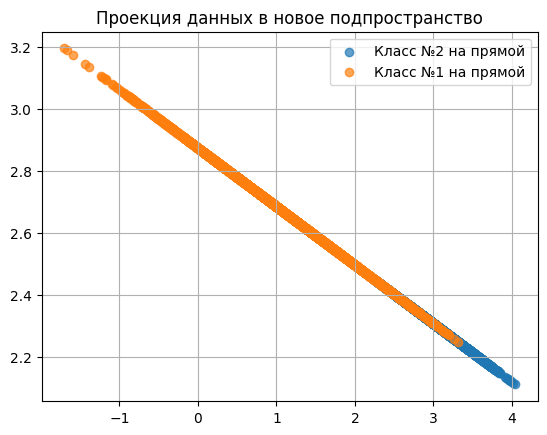

In [24]:
y1 = a+b*train_data_1[:,0]
y2 = a+b*train_data_2[:,0]

plt.scatter(train_data_2[:,0],y2, label='Класс №2 на прямой', alpha=0.7)
plt.scatter(train_data_1[:,0],y1, label='Класс №1 на прямой', alpha=0.7)
plt.title("Проекция данных в новое подпространство")
plt.legend()
plt.grid()
plt.show()

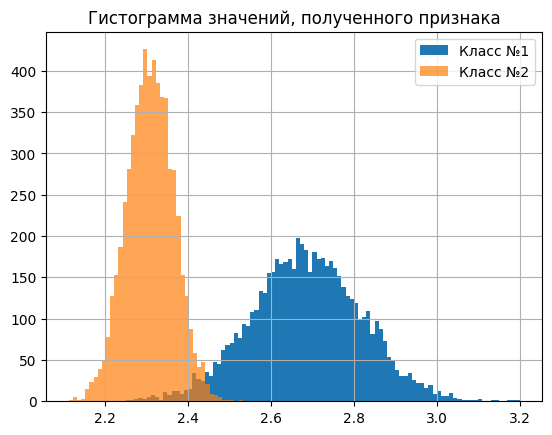

In [25]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.title("Гистограмма значений, полученного признака")
plt.legend()
plt.grid()
plt.show()

Определим пороговое значение y_thr_new

In [ ]:
# Calculate histograms
y1_hist = np.histogram(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth))
y2_hist = np.histogram(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth))

# Find peaks of histograms
y1_max = max(y1_hist[0])
y2_max = max(y2_hist[0])

# Find location of peaks
y1_max_coord = y1_hist[1][np.argwhere(y1_hist[0]==y1_max)[0][0]]
y2_max_coord = y2_hist[1][np.argwhere(y2_hist[0]==y2_max)[0][0]]

In [ ]:
print("Максимальные значения на гистограмме:\nДля первого класса:", y1_max, " достигается при ", y1_max_coord,
      "\nДля второго класса:", y2_max, " достигается при ", y2_max_coord,)

Максимальные значения на гистограмме:
Для первого класса: 186  достигается при  2.7130004105378895 
Для второго класса: 424  достигается при  2.324877163149564


Создать набор порогов

In [ ]:
threshold_range = np.arange(y2_max_coord, y1_max_coord, 0.01)
threshold_range

array([2.32487716, 2.33487716, 2.34487716, 2.35487716, 2.36487716,
       2.37487716, 2.38487716, 2.39487716, 2.40487716, 2.41487716,
       2.42487716, 2.43487716, 2.44487716, 2.45487716, 2.46487716,
       2.47487716, 2.48487716, 2.49487716, 2.50487716, 2.51487716,
       2.52487716, 2.53487716, 2.54487716, 2.55487716, 2.56487716,
       2.57487716, 2.58487716, 2.59487716, 2.60487716, 2.61487716,
       2.62487716, 2.63487716, 2.64487716, 2.65487716, 2.66487716,
       2.67487716, 2.68487716, 2.69487716, 2.70487716])

Функция для расчета суммарной частоты ошибочной классификации

In [ ]:
def count_rel_error(hist_1, hist_2, thr):
    err_1 = np.sum(hist_1[0][np.nonzero(hist_1[1] < thr)[0]])
    err_2 = np.sum(hist_2[0][np.nonzero(hist_2[1] > thr)[0]-1])
    return (err_1+err_2)/(2*N_train)

In [ ]:
error_range = np.array([count_rel_error(y1_hist, y2_hist, thr_x) for thr_x in threshold_range])
thr_new = threshold_range[np.argmin(error_range)]
thr_new

2.464877163149561

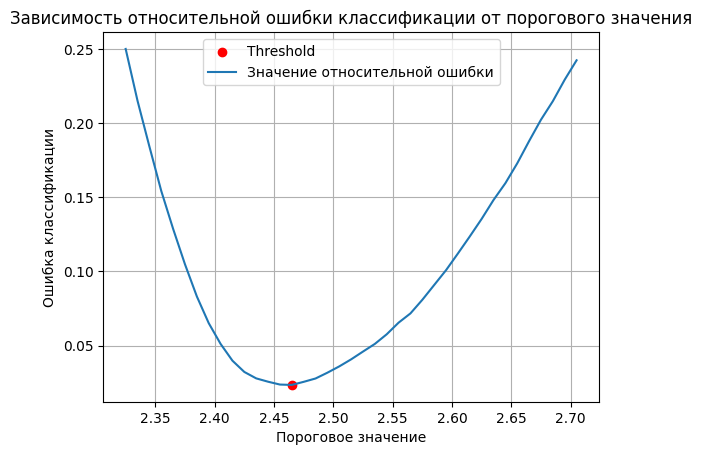

In [ ]:
plt.scatter(thr_new, np.min(error_range), c="r", label='Threshold')
plt.plot(threshold_range, error_range, label='Значение относительной ошибки')
plt.title("Зависимость относительной ошибки классификации от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("Ошибка классификации")
plt.legend()
plt.grid()
plt.show()

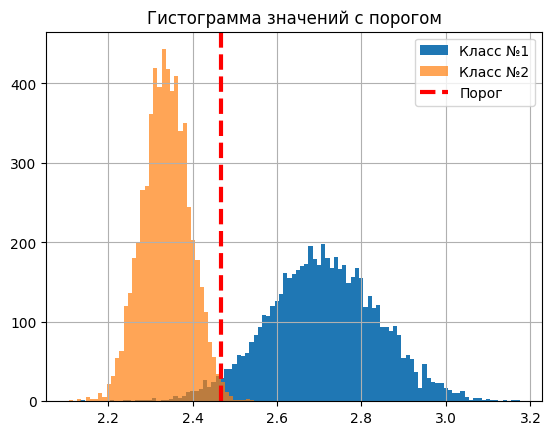

In [ ]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Гистограмма значений с порогом")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("Ошибка на тренировочной выборке составила: %.4f" % np.min(error_range))

Ошибка на тренировочной выборке составила: 0.0226


__До сих пор был этап "обучения" модели__

## 1.4. Рассчитать относительную частоту ошибочной классификации при применении построенного классификатора к группе контроля.
Проекция тестовых данных

In [ ]:
y1_test = a+b*test_data_1[:,0]
y2_test = a+b*test_data_2[:,0]

In [ ]:
# Calculate histograms
y1_hist_test = np.histogram(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth))
y2_hist_test = np.histogram(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth))

In [ ]:
error_test = count_rel_error(y1_hist_test, y2_hist_test, thr_new)

In [ ]:
print("Ошибка на тестовой выборке составила: %.2f" % error_test)

Ошибка на тестовой выборке составила: 0.01


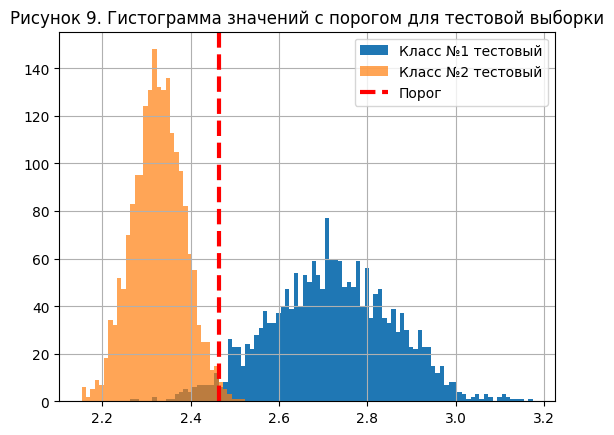

In [ ]:
binwidth = 0.01
plt.hist(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth), label='Класс №1 тестовый', alpha=1.0)
plt.hist(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth), label='Класс №2 тестовый', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Рисунок 9. Гистограмма значений с порогом для тестовой выборки")
plt.legend()
plt.grid()
plt.show()

## 2. Оценка качества классификации
## 2.1. Сгенерировать два набора данных (по 1000 точек в каждом) как реализации двумерного нормального распределения.
Первый набор данных: среднее значение равно [1; 3], СКО = [0,7; 0,8], коэффициент корреляции = 0,2.

In [ ]:
N = 1000
cov_matrix_1 = np.array([[0.7**2, 0.2*0.7*0.8],
                         [0.2*0.7*0.8, 0.8**2]])
mean_value_1 = np.array([1, 3])
data_matrix_1 = np.random.multivariate_normal(mean_value_1, cov_matrix_1, size=N)

Второй набор данных: среднее значение равно [3;2], СКО = [0,3; 1,8], коэффициент корреляции = 0,7

In [ ]:
cov_matrix_2 = np.array([[0.3**2, 0.7*0.3*1.8],
                         [0.7*0.3*1.8, 1.8**2]])
mean_value_2 = np.array([3, 2])
data_matrix_2 = np.random.multivariate_normal(mean_value_2, cov_matrix_2, size=N)

Разделение каждого класса на 10 подвыборок

In [ ]:
class_1_batches = []
for i in range(10):
    class_1_batches.append(data_matrix_1[i*100:(i+1)*100])

class_2_batches = []
for i in range(10):
    class_2_batches.append(data_matrix_2[i*100:(i+1)*100])

Конкатенация данных

In [ ]:
X_batches = []
for i in range(10):
    X_batches.append(np.concatenate((class_1_batches[i], class_2_batches[i]), axis=0))

Генерация меток класса

In [ ]:
temp = np.zeros((200,))
temp[0:100] = 1
temp[100:200] = 2

y_batches = []
for i in range(10):
    y_batches.append(temp)

Перемешивание данных в каждой из десяти подвыборок

In [ ]:
X_shuffled = []
y_shuffled = []
for i in range(10):
    x_b, y_b = shuffle(X_batches[i], y_batches[i], random_state=0)
    X_shuffled.append(x_b)
    y_shuffled.append(y_b)

Создание выборки для обучения из 9 подвыборок и выборки для тестирования из 1 подвыборки

In [ ]:
X_train = np.reshape(np.array(X_shuffled[0:9]), (9*200, 2))
y_train = np.reshape(np.array(y_shuffled[0:9]), (9*200, ))

X_test = np.reshape(np.array(X_shuffled[9:10]), (1*200, 2))
y_test = np.reshape(np.array(y_shuffled[9:10]), (1*200, ))

Полный набор данных для кросс-валидации

In [ ]:
X_cross_val = np.reshape(np.array(X_shuffled[:]), (10*200, 2))
y_cross_val = np.reshape(np.array(y_shuffled[:]), (10*200, ))

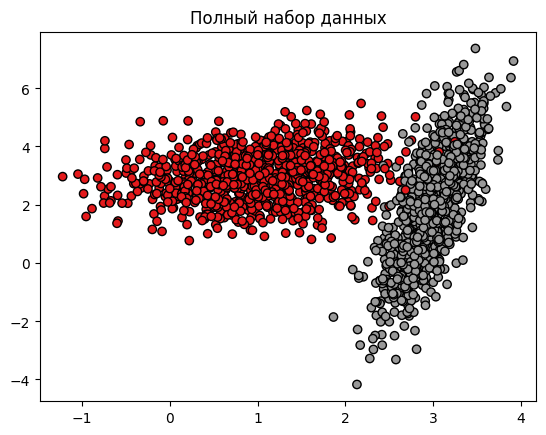

In [ ]:
plt.scatter(X_cross_val[:, 0], X_cross_val[:, 1], c=y_cross_val, cmap="Set1", edgecolors='k')
plt.title("Полный набор данных")
plt.show()

## 2.2. LDA реализуемый в пакете Scikit-learn
Напишем функцию для графического представления матрицы несоответствия

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

Напишем функцию для графического представления результатов классификации

In [ ]:
def plot_classification_boundary(name, clf):
    """
    This function prints and plots the confusion matrix.
    """
    figure = plt.figure(figsize=(6, 6))

    h = .02  # step size in the mesh
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(1,1,1)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k', alpha=0.2, label="Train")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                     edgecolors='k', alpha=1, label="Test")
    ax.set_title(name)
    ax.legend()

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('Score = %.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

Применим линейный дискриминантный анализ

[[ 7.76226004 -1.47351651]]
Модель 1. Линейный дискриминантный анализ
              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       100
         2.0       0.92      1.00      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200

[[ 91   9]
 [  0 100]]


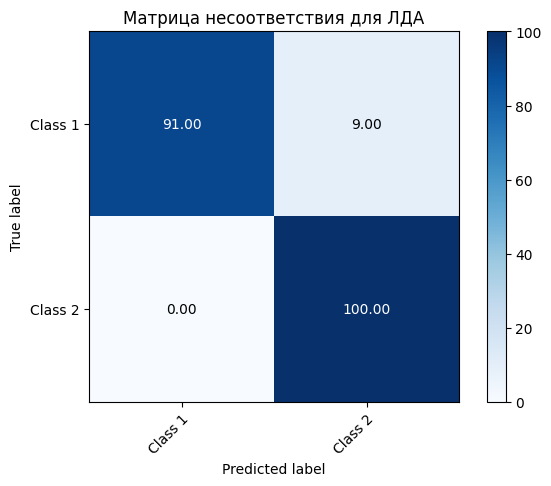

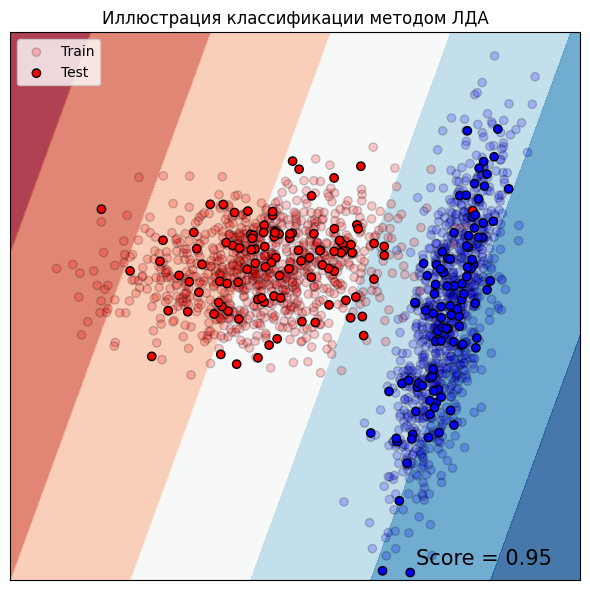

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
print(clf.coef_)
expected = y_test
predicted = clf.predict(X_test)

print("Модель 1. Линейный дискриминантный анализ")
print(metrics.classification_report(expected, predicted))
plot_confusion_matrix(expected, predicted, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия для ЛДА")
plt.plot()
plot_classification_boundary("Иллюстрация классификации методом ЛДА", clf)

## 2.3. Провести кросс-валидацию модели, оценить математическое ожидание ошибки и построить доверительный интервал


In [ ]:
clf_best = LinearDiscriminantAnalysis()
scores = cross_val_score(clf_best, X_cross_val, y_cross_val, cv=10)

Вероятность ошибки на каждой из 10 частей выборки составила:

In [ ]:
1 - scores

array([0.025, 0.02 , 0.02 , 0.01 , 0.   , 0.05 , 0.03 , 0.05 , 0.05 ,
       0.05 ])

Среднее значение ошибки классификации составило:

In [ ]:
mean_error = (1 - scores).mean()
mean_error

0.030500000000000027

Оценим общее число ошибок классификации на кажой из 10 частей выборки

[[ 939   61]
 [   0 1000]]


[]

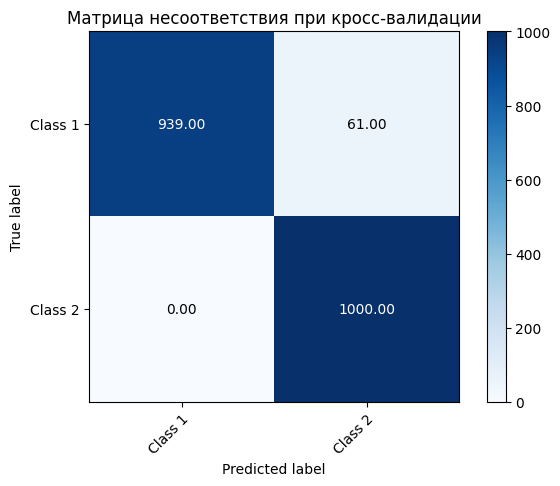

In [ ]:
y_pred = cross_val_predict(clf_best, X_cross_val, y_cross_val, cv=10)
value = plot_confusion_matrix(y_cross_val, y_pred, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия при кросс-валидации")
plt.plot()

Следовательно, при общем числе классифицируемых объектов, равном 2000, число ошибок классификации составило:

In [ ]:
num_samples = 2000
num_errors = value[1][0, 1] + value[1][1, 0]
num_errors

61

Определим довреительный интервал для матемтического ожидания ошибки с учетом значения c-квантиля распределения Фишера

In [ ]:
def conf_interval(numerator, denominator_coef, quantile, df_1, df_2):
    return (1 + numerator/(denominator_coef*stats.f.ppf(quantile, df_1, df_2)))**(-1)

In [ ]:
alpha = 0.95

In [ ]:
left_lim = conf_interval(numerator=(num_samples-num_errors+1),
                         denominator_coef=num_errors,
                         quantile=(alpha/2),
                         df_1=(2*num_errors),
                         df_2=(2*(num_samples-num_errors+1)))

right_lim = conf_interval(numerator=(num_samples-num_errors),
                          denominator_coef=(num_errors+1),
                          quantile=(1-alpha/2),
                          df_1=(2*(num_errors+1)),
                          df_2=(2*(num_samples-num_errors)))

Таким образом, математическое ожидание ошибки классификации составляет:

In [ ]:
print("%.4f"%mean_error)

0.0305


С доверительным интервалом:

In [ ]:
print("[%.4f,%.4f]"%(left_lim, right_lim))

[0.0301,0.0311]


и уровнем доверия alpha = 0.95

#Задание

1. Произвести снижение размерности данных в датасете load_breast_cancer() с использованием LDA, построить гистограммы распредления данных после проекции
2. Произвести классификацию с LDA, построить матрицу неточности, рассчитать метрики классификации на train и test наборах, на кросс-валидации

In [ ]:
from sklearn import datasets

data = datasets.load_breast_cancer()